# 07 – Cross-Validation (Transformers: DistilBERT/BERT)

Ziel: Robuste Evaluation mittels k-fold Cross-Validation für Transformer-Modelle.
Pro Fold wird das Modell neu initialisiert und auf dem Trainingsfold fine-getuned.
Als Resultat werden Mittelwert und Standardabweichung von Accuracy und Macro-F1 berichtet.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed,
)

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results" / "cross_validation"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("CUDA available:", torch.cuda.is_available())
print("DATA_CSV:", DATA_CSV)
print("RESULTS_DIR:", RESULTS_DIR)


CUDA available: True
DATA_CSV: c:\CAS\cas-ml-document-classification\data\processed\bbc_news.csv
RESULTS_DIR: c:\CAS\cas-ml-document-classification\results\cross_validation


Daten laden + Label Mapping

In [2]:
df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

print("Samples:", len(X))
print("Classes:", labels_sorted)


Samples: 2225
Classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


Tokenizer + Tokenize-Funktion (Tokenzier einmal laden, nicht pro Feld)

In [3]:
MODEL_NAME = "distilbert-base-uncased"   # oder "bert-base-uncased"
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Metrics

In [4]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    mf1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": mf1}


Trainer Builder

In [5]:
def build_trainer(train_ds, eval_ds, fold_id, seed=42,
                  epochs=2, batch_size=16, lr=2e-5):
    set_seed(seed)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    )

    args = TrainingArguments(
        output_dir=str(RESULTS_DIR / f"tmp_fold_{fold_id}"),
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="no",          # wir speichern hier nicht pro Fold die weights (optional)
        logging_strategy="no",
        report_to="none",
        seed=seed
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    return trainer


Cross-Validation Loop

In [6]:
N_SPLITS = 3     # später ggf. 5
EPOCHS = 2
BATCH_SIZE = 16
LR = 2e-5
SEED = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_rows = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"\n=== Fold {fold}/{N_SPLITS} ===")

    X_tr, y_tr = X[train_idx], y[train_idx]
    X_va, y_va = X[val_idx], y[val_idx]

    train_ds = Dataset.from_dict({"text": list(X_tr), "label": list(y_tr)}).map(tokenize_batch, batched=True)
    val_ds   = Dataset.from_dict({"text": list(X_va), "label": list(y_va)}).map(tokenize_batch, batched=True)

    # Torch format für Trainer
    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    trainer = build_trainer(
        train_ds, val_ds,
        fold_id=fold,
        seed=SEED,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR
    )

    trainer.train()
    res = trainer.evaluate()

    fold_rows.append({
        "model": MODEL_NAME,
        "fold": fold,
        "n_splits": N_SPLITS,
        "max_length": MAX_LENGTH,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "lr": LR,
        "eval_accuracy": float(res["eval_accuracy"]),
        "eval_macro_f1": float(res["eval_macro_f1"]),
        "eval_loss": float(res["eval_loss"])
    })

df_cv = pd.DataFrame(fold_rows)
df_cv



=== Fold 1/3 ===


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.2075062394142151, 'eval_accuracy': 0.9690026954177897, 'eval_macro_f1': 0.9682100638248334, 'eval_runtime': 1.0431, 'eval_samples_per_second': 711.36, 'eval_steps_per_second': 45.059, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.12415092438459396, 'eval_accuracy': 0.9757412398921833, 'eval_macro_f1': 0.9750572030517048, 'eval_runtime': 0.994, 'eval_samples_per_second': 746.446, 'eval_steps_per_second': 47.282, 'epoch': 2.0}
{'train_runtime': 15.2733, 'train_samples_per_second': 194.195, 'train_steps_per_second': 12.178, 'train_loss': 0.4465034648936282, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]


=== Fold 2/3 ===


Map:   0%|          | 0/1483 [00:00<?, ? examples/s]

Map:   0%|          | 0/742 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.21360144019126892, 'eval_accuracy': 0.9811320754716981, 'eval_macro_f1': 0.9812210754585158, 'eval_runtime': 0.999, 'eval_samples_per_second': 742.74, 'eval_steps_per_second': 47.047, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.10522148013114929, 'eval_accuracy': 0.9824797843665768, 'eval_macro_f1': 0.9824181733412614, 'eval_runtime': 0.9992, 'eval_samples_per_second': 742.615, 'eval_steps_per_second': 47.039, 'epoch': 2.0}
{'train_runtime': 14.7378, 'train_samples_per_second': 201.251, 'train_steps_per_second': 12.621, 'train_loss': 0.4584508506200647, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]


=== Fold 3/3 ===


Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/741 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.20533855259418488, 'eval_accuracy': 0.97165991902834, 'eval_macro_f1': 0.9710759824096092, 'eval_runtime': 1.0036, 'eval_samples_per_second': 738.328, 'eval_steps_per_second': 46.831, 'epoch': 1.0}


  0%|          | 0/47 [00:00<?, ?it/s]

{'eval_loss': 0.11135325580835342, 'eval_accuracy': 0.9824561403508771, 'eval_macro_f1': 0.9822098106842656, 'eval_runtime': 1.0008, 'eval_samples_per_second': 740.377, 'eval_steps_per_second': 46.96, 'epoch': 2.0}
{'train_runtime': 14.7799, 'train_samples_per_second': 200.814, 'train_steps_per_second': 12.585, 'train_loss': 0.4528031297909316, 'epoch': 2.0}


  0%|          | 0/47 [00:00<?, ?it/s]

,model,fold,n_splits,max_length,epochs,batch_size,lr,eval_accuracy,eval_macro_f1,eval_loss
0,distilbert-base-uncased,1,3,256,2,16,0.00002,0.975741,0.975057,0.124151
1,distilbert-base-uncased,2,3,256,2,16,0.00002,0.982480,0.982418,0.105221
2,distilbert-base-uncased,3,3,256,2,16,0.00002,0.982456,0.982210,0.111353


Mean / Std berechnen

In [7]:
summary = {
    "model": MODEL_NAME,
    "n_splits": N_SPLITS,
    "acc_mean": df_cv["eval_accuracy"].mean(),
    "acc_std": df_cv["eval_accuracy"].std(ddof=1),
    "mf1_mean": df_cv["eval_macro_f1"].mean(),
    "mf1_std": df_cv["eval_macro_f1"].std(ddof=1),
}

summary


{'model': 'distilbert-base-uncased',
 'n_splits': 3,
 'acc_mean': 0.9802257215365456,
 'acc_std': 0.003883693020030976,
 'mf1_mean': 0.9798950623590773,
 'mf1_std': 0.004191004146699818}

Expoert CSV

In [8]:
fold_path = RESULTS_DIR / f"cv_{MODEL_NAME.replace('/', '_')}_{N_SPLITS}fold_folds.csv"
sum_path  = RESULTS_DIR / f"cv_{MODEL_NAME.replace('/', '_')}_{N_SPLITS}fold_summary.csv"

df_cv.to_csv(fold_path, index=False)
pd.DataFrame([summary]).to_csv(sum_path, index=False)

fold_path, sum_path


(WindowsPath('c:/CAS/cas-ml-document-classification/results/cross_validation/cv_distilbert-base-uncased_3fold_folds.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/cross_validation/cv_distilbert-base-uncased_3fold_summary.csv'))

Plot: Fold Results

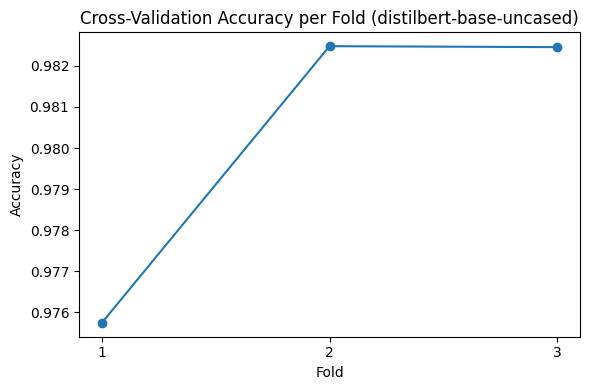

WindowsPath('c:/CAS/cas-ml-document-classification/results/cross_validation/cv_distilbert-base-uncased_3fold_accuracy.png')

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df_cv["fold"], df_cv["eval_accuracy"], marker="o")
plt.xticks(df_cv["fold"])
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title(f"Cross-Validation Accuracy per Fold ({MODEL_NAME})")
plt.tight_layout()
plot_path = RESULTS_DIR / f"cv_{MODEL_NAME.replace('/', '_')}_{N_SPLITS}fold_accuracy.png"
plt.savefig(plot_path, dpi=300)
plt.show()

plot_path
